In [1]:
%cd ../

/Users/sarchey1/paper/FederatedLearning


In [2]:
import warnings
warnings.simplefilter('ignore')

## Stochastic Block Model Experiment

Before geting into the experiment details, let's review algorithm 1 and the primal and dual updates.

### Algorithm 1

![title](../gradient_federated.png)

In [3]:
# %load algorithm/main.py
from sklearn.metrics import mean_squared_error

from algorithm.penalty import *


def algorithm_1(K, D, weight_vec, features, true_labels, samplingset, lambda_lasso, calculate_score=False):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param features: a list containing the local datapints of the nodes
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    alpha = 0.02
    E, N = D.shape
    m, n = features[0].shape

    # starting algorithm 1

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''

    iteration_scores = []
    for iterk in range(K):
        prev_w = np.copy(new_w)
        # line 2 of Gradient descent for networked FL
        new_w = np.array([np.zeros(n) for i in range(N)])

        # line 3 of Gradient descent for networked FL
        for i in range(N):
            if i in samplingset:  
                # line 4 of Gradient descent for networked FL
#                 optimizer = datapoints[i]['optimizer']
#                 new_w[i] = 1/m * optimizer.optimize(datapoints[i]['features'], datapoints[i]['label'], prev_w[i], datapoints[i]['degree'])
                
                # line 4 of Gradient descent for networked FL
                var = np.dot(features[i], prev_w[i]) - true_labels[i]
                new_w[i] = 1/m * np.dot(features[i].T, var)


        # line 6 of Gradient descent for networked FL
        for e in range(E):
            i = np.where(B[e]==1)[0]
            j = np.where(B[e]==-1)[0]
            
            # line 7 of Gradient descent for networked FL
            tilde_w = lambda_lasso * weight_vec[e] * (prev_w[j] - prev_w[i])
            
            # line 8 of Gradient descent for networked FL
            new_w[i] = new_w[i] - tilde_w
            
            # line 9 of Gradient descent for networked FL
            new_w[j] = new_w[j] + tilde_w
            

        # line 11 of Gradient descent for networked FL
        new_w = prev_w - alpha * new_w

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(features[i], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w


In [4]:
# %load algorithm/main.py
from sklearn.metrics import mean_squared_error
import torch.nn.functional as F


def joonas_algorithm_1(K, D, weight_vec, features, true_labels, samplingset, lambda_lasso, calculate_score=False):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param features: a list containing the local datapints of the nodes
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    E, N = D.shape
    m, n = features[0].shape

    # starting algorithm 1

    # step size, 0.0001
    # last 0.05
    a = 0.02
    
    D = torch.Tensor(D)
    weight_vec = torch.Tensor(weight_vec)
    
    iteration_scores = []
    
    model_params = list()
    models = []
    for i in range(N):
        model = TorchLinearModel(n)
        models.append(model)
        model_params += list(model.parameters())

    optim = torch.optim.SGD(model_params, lr=a)
    prev_loss = 0
    iterations = K
    
    for iterk in range(K):
        optim.zero_grad()
        # Shared loss over all nodes
        loss = 0
        # f(w) (training error/loss)
        for i in samplingset:
            x_i = torch.Tensor(features[i])
            y_i = torch.Tensor(true_labels[i]).reshape(-1, 1)
            y_pred = models[i](x_i)
            loss1 = F.mse_loss(y_pred, y_i)
            loss += loss1
                
        # GTV
        # weight_vec is A (edge weights)
        # D is sort of adjacency matrix? +1 on j and -1 on i
        # new_w has the current weights
        new_w = torch.cat([models[i].linear.weight for i in range(N)])
        # w_j - w_i = D @ new_w
        norm_squared = torch.square(torch.linalg.norm(D @ new_w, dim=1))
        loss2 = lambda_lasso * torch.dot(weight_vec, norm_squared)
        loss += loss2
        
#         print("epoch:", iterk)
#         print("loss", loss.item())
        if prev_loss - loss < 0.0005 and prev_loss - loss >= 0:
            iterations = iterk
            break
        else:
            prev_loss = loss
        
        loss.backward()
        optim.step()
        

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(models[i](features[i]))
            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))
    
    new_w = np.array([models[i].linear.weight.data.numpy() for i in range(N)]).reshape((N, -1))

    return iteration_scores, new_w, iterations



## primal dual implementation

In [32]:
# %load algorithm/main.py
from sklearn.metrics import mean_squared_error

from algorithm.penalty import *


def primal_dual_algorithm_1(K, D, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func_name='norm1', calculate_score=False):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    '''
    Sigma: the block diagonal matrix Sigma
    '''
    T_matrix = np.diag(np.array((1.0 / (np.sum(abs(D), 0)))).ravel())
    '''
    T_matrix: the block diagonal matrix T
    '''

    if np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2) > 1:
        print ('product norm', np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2))

    E, N = D.shape
    m, n = datapoints[0]['features'].shape

    # define the penalty function
    if penalty_func_name == 'norm1':
        penalty_func = Norm1Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'norm2':
        penalty_func = Norm2Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'mocha':
        penalty_func = MOCHAPelanty(lambda_lasso, weight_vec, Sigma, n)

    else:
        raise Exception('Invalid penalty name')

    # starting algorithm 1

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''
    new_u = np.array([np.zeros(n) for i in range(E)])
    '''
    new_u: the dual variable of the algorithm 1
    '''

    iteration_scores = []
    for iterk in range(K):
        # if iterk % 100 == 0:
        #     print ('iter:', iterk)
        prev_w = np.copy(new_w)

        # algorithm 1, line 2
        hat_w = new_w - np.dot(T_matrix, np.dot(D.T, new_u))

        for i in range(N):
            if i in samplingset:  # algorithm 1, line 6

                optimizer = datapoints[i]['optimizer']
                new_w[i] = optimizer.optimize(datapoints[i]['features'], datapoints[i]['label'], hat_w[i], datapoints[i]['degree'])

            else:
                new_w[i] = hat_w[i]

        # algorithm 1, line 9
        tilde_w = 2 * new_w - prev_w
        new_u = new_u + np.dot(Sigma, np.dot(D, tilde_w))

        # algorithm 1, line 10
        new_u = penalty_func.update(new_u)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(datapoints[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w



# %load algorithm/optimizer.py 
import torch
import abc
import numpy as np

from abc import ABC


# The linear model which is implemented by pytorch
class TorchLinearModel(torch.nn.Module):
    def __init__(self, n):
        super(TorchLinearModel, self).__init__()
        self.linear = torch.nn.Linear(n, 1, bias=False)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred


# The abstract optimizer model which should have model, optimizer, and criterion as the input
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(40):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear.weight - torch_old_weight) ** 2)  # + 10000*torch.mean((model.linear.bias+0.5)**2)#model.linear.weight.norm(2)
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()


# The linear model in Networked Linear Regression section of the paper
class LinearModel:
    def __init__(self, degree, features, label):
        mtx1 = 2 * degree * np.dot(features.T, features).astype('float64')
        mtx1 += 1 * np.eye(mtx1.shape[0])
        mtx1_inv = np.linalg.inv(mtx1)

        mtx2 = 2 * degree * np.dot(features.T, label).T

        self.mtx1_inv = mtx1_inv
        self.mtx2 = mtx2

    def forward(self, x):
        mtx2 = x + self.mtx2
        mtx_inv = self.mtx1_inv

        return np.dot(mtx_inv, mtx2)


# The Linear optimizer in Networked Linear Regression section of the paper
class LinearOptimizer(Optimizer):

    def __init__(self, model):
        super(LinearOptimizer, self).__init__(model, None, None)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return self.model.forward(old_weight)


# The Linear optimizer model which is implemented by pytorch
class TorchLinearOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLinearOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLinearOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)


# The Logistic optimizer model which is implemented by pytorch
class TorchLogisticOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.BCELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLogisticOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLogisticOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)



# %load algorithm/penalty.py
import abc
import numpy as np

from abc import ABC


# The abstract penalty function which has a function update
class Penalty(ABC):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        self.lambda_lasso = lambda_lasso
        self.weight_vec = weight_vec
        self.Sigma = Sigma

    @abc.abstractmethod
    def update(self, new_u):
        pass


# The norm2 penalty function
class Norm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array(lambda_lasso * weight_vec)

    def update(self, new_u):
        normalized_u = np.where(np.linalg.norm(new_u, axis=1) >= self.limit)
        new_u[normalized_u] = (new_u[normalized_u].T * self.limit[normalized_u] / np.linalg.norm(new_u[normalized_u], axis=1)).T
        return new_u


# The MOCHA penalty function
class MOCHAPelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(MOCHAPelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(2 * self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u


# The norm1 penalty function
class Norm1Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm1Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array([np.zeros(n) for i in range(len(weight_vec))])
        for i in range(n):
            self.limit[:, i] = lambda_lasso * weight_vec

    def update(self, new_u):
        normalized_u = np.where(abs(new_u) >= self.limit)
        new_u[normalized_u] = self.limit[normalized_u] * new_u[normalized_u] / abs(new_u[normalized_u])
        return new_u




### FedAvg

In [31]:
from sklearn.metrics import mean_squared_error

from algorithm.penalty import *


def fedAvg(K, datapoints, true_labels, samplingset, calculate_score=False):
    '''
    :param K: the number of iterations
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param true_labels: a list containing the true labels of the nodes
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    N = len(datapoints)
    m, n = datapoints[0]['features'].shape

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the weights
    '''

    iteration_scores = []
    for iterk in range(K):
        for i in samplingset:
            optimizer = datapoints[i]['optimizer']
            new_w[i] = optimizer.optimize(
                datapoints[i]['features'], 
                datapoints[i]['label'], 
                new_w[i], 
                datapoints[i]['degree']
            )
        new_w[:, :] = np.mean(new_w[samplingset], axis=0)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(datapoints[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w



## Create SBM Graph

The stochastic block model is a generative model for random graphs with some clusters structure. Two nodes within the same cluster of the empirical graph are connected by an edge with probability pin, two nodes from different clusters are connected by an edge with probability pout. Each node $i \in V$ represents a local dataset consisting of $m$ feature vectors $x^{(i,1)}, ... , x^{(i,m)} \in R^n$. The feature vectors are i.i.d. realizations of a standard Gaussian random vector x ∼ N(0,I). The labels $y_1^{(i)}, . . . , y_m^{(i)} \in R$ of the nodes $i \in V$ are generated according to the linear model $y_r^{(i)} = (x^{(i, r)})^T w^{(i)} + \epsilon$, with $\epsilon ∼ N(0,\sigma)$. To learn the weight $w^{(i)}$ ,we apply Algorithm 1 to a training set M obtained by randomly selecting 40% of the nodes.

In [14]:
from algorithm.optimizer import *
from torch.autograd import Variable


def get_sbm_data(cluster_sizes, G, W, m=5, n=2, noise_sd=0):
    '''
    :param G: generated SBM graph with defined clusters using sparsebm.generate_SBM_dataset
    :param W: a list containing the weight vectors for each cluster
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''

    N = len(G.nodes)
    E = len(G.edges)
    '''
    N: total number of nodes
    E: total number of edges
    '''
    
    
    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph with the shape of E*N
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph with the shape of E
    '''
    
    cnt = 0
    for i, j in G.edges:
        if i > j:
            continue
        B[cnt, i] = 1
        B[cnt, j] = -1

        weight_vec[cnt] = 1
        cnt += 1
    
    weight_vec = weight_vec[:cnt]
    B = B[:cnt, :]
    
    # create the data of each node needed for the algorithm 1 
    
    node_degrees = np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    '''
    node_degrees: a list containing the nodes degree for the alg1 (1/N_i)
    '''
    
    datapoints = {}
    '''
    datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1,
    which are features, label, degree, and also the optimizer model for each node
    '''
    true_labels = []
    '''
    true_labels: the true labels for the nodes of the graph
    '''
    
    cnt = 0
    for i, cluster_size in enumerate(cluster_sizes):
        for j in range(cluster_size):
            features = np.random.normal(loc=0.0, scale=1.0, size=(m, n))
            '''
            features: the feature vector of node i which are i.i.d. realizations of a standard Gaussian random vector x~N(0,I)
            '''
            label = np.dot(features, W[i]) + np.random.normal(0,noise_sd)
            '''
            label: the label of the node i that is generated according to the linear model y = x^T w + e
            '''
            
            true_labels.append(label)

            model = LinearModel(node_degrees[i], features, label)
            optimizer = LinearOptimizer(model)            
            '''
            model : the linear model for the node i 
            optimizer : the optimizer model for the node i 
            ''' 
            
            datapoints[cnt] = {
                'features': features,
                'degree': node_degrees[i],
                'label': label,
                'optimizer': optimizer
            }
            cnt += 1
            
    
    features = [datapoints[i]['features'] for i in datapoints]

    return B, weight_vec, features, np.array(true_labels), datapoints




### Compare Results

As the result we compare the MSE of Algorithm 1 with plain linear regression 
and decision tree regression

In [22]:
# %load results/compare_results.py
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


def get_algorithm1_MSE(all_features, labels, predicted_w, samplingset):
    '''
    :param datapoints:  a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param predicted_w: the predicted weigh vectors for each node
    :param samplingset: the sampling set for the algorithm 1

    :return alg1_MSE: the MSE of the algorithm 1 for all the nodes, the samplingset and other nodes (test set)
    '''
    not_samplingset = [i for i in range(len(datapoints)) if i not in samplingset]

    true_labels = []
    pred_labels = []
    for i in range(len(all_features)):
        features = np.array(all_features[i])
        label = np.array(labels[i])
        true_labels.append(label)

        pred_labels.append(np.dot(features, predicted_w[i]))

    pred_labels = np.array(pred_labels)
    true_labels = np.array(true_labels)

    alg1_MSE = {'total': mean_squared_error(true_labels, pred_labels),
                'train': mean_squared_error(true_labels[samplingset], pred_labels[samplingset]),
                'test': mean_squared_error(true_labels[not_samplingset], pred_labels[not_samplingset])}

    return alg1_MSE


def get_linear_regression_MSE(x, y, samplingset, not_samplingset):
    '''
    :param x: a list containing the features of the nodes
    :param y: a list containing the labels of the nodes
    :param samplingset: the training dataset
    :param not_samplingset: the test dataset
    :return linear_regression_MSE : the MSE of linear regression for all the nodes, the samplingset and other nodes (test set)
    '''

    model = LinearRegression().fit(x[samplingset], y[samplingset])
    pred_y = model.predict(x)

    linear_regression_MSE = {'total': mean_squared_error(y, pred_y),
                             'train': mean_squared_error(y[samplingset],
                                                         pred_y[samplingset]),
                             'test': mean_squared_error(y[not_samplingset],
                                                        pred_y[not_samplingset])}

    return linear_regression_MSE


def get_decision_tree_MSE(x, y, samplingset, not_samplingset):
    '''
    :param x: a list containing the features of the nodes
    :param y: a list containing the labels of the nodes
    :param samplingset: the training dataset
    :param not_samplingset: the test dataset
    :return decision_tree_MSE : the MSE of decision tree for all the nodes, the samplingset and other nodes (test set)
    '''

    max_depth = 2

    regressor = DecisionTreeRegressor(max_depth=max_depth)
    regressor.fit(x[samplingset], y[samplingset])
    pred_y = regressor.predict(x)

    decision_tree_MSE = {'total': mean_squared_error(y, pred_y),
                         'train': mean_squared_error(y[samplingset],
                                                     pred_y[samplingset]),
                         'test': mean_squared_error(y[not_samplingset],
                                                    pred_y[not_samplingset])}
    return decision_tree_MSE


def get_scores(features, labels, primal_dual_w, predicted_w, joona_w, fl_w, samplingset, others=True):
    N = len(features)
    print(len(features), len(labels))
    '''
    N : the total number of nodes
    '''

    # calculate algorithm1 MSE
    alg_1_score = get_algorithm1_MSE(features, labels, predicted_w, samplingset)
    primal_dual_score = get_algorithm1_MSE(features, labels, primal_dual_w, samplingset)
    joonas_score = get_algorithm1_MSE(features, labels, joona_w, samplingset)
    fl_score = get_algorithm1_MSE(features, labels, fl_w, samplingset)
    
    linear_regression_score = None
    decision_tree_score = None

    if others:
        # prepare the data for calculating the linear regression and decision tree regression MSEs
        X = []
        '''
        X: an array containing the features of all the nodes
        '''
        true_labels = []
        '''
        true_labels: an array containing the labels of all the nodes
        '''
        for i in range(len(datapoints)):
            X.append(np.array(datapoints[i]['features']))
            true_labels.append(np.array(datapoints[i]['label']))

        X = np.array(X)
        true_labels = np.array(true_labels)
        m, n = X[0].shape

        x = X.reshape(-1, n)
        y = true_labels.reshape(-1, 1)

        reformated_samplingset = []
        for item in samplingset:
            for i in range(m):
                reformated_samplingset.append(m * item + i)
        reformated_not_samplingset = [i for i in range(m * N) if i not in reformated_samplingset]
        
        # calculate linear regression MSE
        linear_regression_score = get_linear_regression_MSE(x, y, reformated_samplingset, reformated_not_samplingset)

        # calculate decision tree MSE
        decision_tree_score = get_decision_tree_MSE(x, y, reformated_samplingset, reformated_not_samplingset)

    return alg_1_score, joonas_score, primal_dual_score, fl_score, linear_regression_score, decision_tree_score


### SBM with Two Clusters

This SBM has two clusters $|C_1| = |C_2| = 100$.
Two nodes within the same cluster are connected by an edge with probability `pin=0.5`, 
and two nodes from different clusters are connected by an edge with probability `pout=0.01`. 
Each node $i \in V$ represents a local dataset consisting of feature vectors $x^{(i,1)}, ... , x^{(i,5)} \in R^2$.
The feature vectors are i.i.d. realizations of a standard Gaussian random vector x ~ N(0,I).
The labels $y_1^{(i)}, . . . , y_5^{(i)} \in R$ for each node $i \in V$
are generated according to the linear model $y_r^{(i)} = (x^{(i, r)})^T w^{(i)} + \epsilon$, with $\epsilon = 0$. 
The tuning parameter $\lambda$ in algorithm1 
is manually chosen, guided by the resulting MSE, as $\lambda=0.01$ for norm1 and norm2 and also $\lambda=0.05$ for mocha penalty function. 
To learn the weight $w^{(i)}$ ,we apply Algorithm 1 to a training set M obtained by randomly selecting 40% of the nodes and use the rest as test set. As the result we compare the mean MSE of Algorithm 1 with plain linear regression and decision tree regression with respect to the different random sampling sets.

In [16]:
%%capture
# from sparsebm import generate_SBM_dataset
import networkx as nx


def get_sbm_2blocks_data(m=5, n=2, pin=0.5, pout=0.01, noise_sd=0):
    '''
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''
    cluster_sizes = [50, 50]
    probs = np.array([[pin, pout],[pout, pin]])

    G = nx.stochastic_block_model(cluster_sizes, probs, seed=0)
    '''
    G: generated SBM graph with 2 clusters
    ''' 
    
    # define weight vectors for each cluster of the graph
    
    W1 = np.array([2 for i in range(n)])
    '''
    W1: the weigh vector for the first cluster
    '''
    W2 = np.array([-2 for i in range(n)])
    '''
    W2: the weigh vector for the second cluster
    '''
    
    W = [W1, W2]
    
    
    return get_sbm_data(cluster_sizes, G, W, m, n, noise_sd)



Plot the MSE with respect to the different random sampling sets for each penalty function, the plots are in the log scale

## Results 

### Number of features: 2   
### Number of datapoints per node: 5

In [23]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


K = 1000

B, weight_vec, features, true_labels, datapoints = get_sbm_2blocks_data(pin=1.0, pout=0.01)
E, N = B.shape

alg1_scores = []
joonas_scores = []
primal_dual_scores = []
fl_scores = []
linear_regression_scores = []
decision_tree_scores = []

num_tries = 5
num_tries = 1

from joblib import Parallel, delayed
import multiprocessing
def fun():
    samplingset = random.sample([j for j in range(N)], k=int(0.4* N)) 
    lambda_lasso = 0.1
    _, primal_dual_w = primal_dual_algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso)
    _, predicted_w = algorithm_1(K, B, weight_vec, features, true_labels, samplingset, lambda_lasso)
    _, joona_w, _ = joonas_algorithm_1(K, B, weight_vec, features, true_labels, samplingset, lambda_lasso)
    _, fl_w = fedAvg(K, datapoints, true_labels, samplingset)

    return get_scores(features, true_labels, primal_dual_w, predicted_w, joona_w, fl_w, samplingset)


# results = Parallel(n_jobs=4)(delayed(fun)() 
#                                          for i in range(num_tries))

results = [fun()]

for scores in results:
    alg1_score, joonas_score, primal_dual_score, fl_score, linear_regression_score, decision_tree_score = scores
    alg1_scores.append(alg1_score)
    joonas_scores.append(joonas_score)
    primal_dual_scores.append(primal_dual_score)
    fl_scores.append(fl_score)
    linear_regression_scores.append(linear_regression_score)
    decision_tree_scores.append(decision_tree_score)

100 100


algorithm 1: 
 mean train MSE: 0.2817479036658649 
 mean test MSE: 0.5087006586757117
joonas algorithm 1: 
 mean train MSE: 0.2951966897638429 
 mean test MSE: 0.5354136266238652
primal dual algorithm 1: 
 mean train MSE: 0.00031477655262718925 
 mean test MSE: 0.00035121734183543194
federated learning: 
 mean train MSE: 7.22546254742246 
 mean test MSE: 7.836308514334607
linear regression: 
 mean train MSE: 7.207770386524253 
 mean test MSE: 7.877151061038024
decision tree: 
 mean train MSE: 5.905124933127341 
 mean test MSE: 9.58611137463456


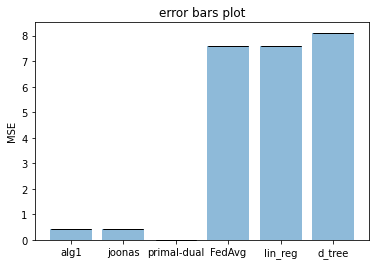

In [24]:
labels = ['alg1', 'joonas', 'primal-dual', 'FedAvg', 'lin_reg', 'd_tree']
x_pos = np.arange(len(labels))
    
    
print('algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in alg1_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in alg1_scores]))

print('joonas algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in joonas_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in joonas_scores]))

print('primal dual algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in primal_dual_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in primal_dual_scores]))

print('federated learning:', 
      '\n mean train MSE:', np.mean([item['train'] for item in fl_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in fl_scores])) 
                                                                         
print('linear regression:', 
      '\n mean train MSE:', np.mean([item['train'] for item in linear_regression_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in linear_regression_scores]))

print('decision tree:', 
      '\n mean train MSE:', np.mean([item['train'] for item in decision_tree_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in decision_tree_scores]))
    
alg1_norm1_score = [item['total'] for item in alg1_scores]
joonas_score = [item['total'] for item in joonas_scores]
primal_dual_score = [item['total'] for item in primal_dual_scores]
fl_score = [item['total'] for item in fl_scores]  
linear_regression_score = [item['total'] for item in linear_regression_scores]
decision_tree_score = [item['total'] for item in decision_tree_scores]

mean_MSEs = [
    np.mean(alg1_norm1_score), 
    np.mean(joonas_score), 
    np.mean(primal_dual_score), 
    np.mean(fl_score), 
    np.mean(linear_regression_score), 
    np.mean(decision_tree_score)
]

std_MSEs = [
    np.std(alg1_norm1_score), 
    np.std(joonas_score), 
    np.std(primal_dual_score), 
    np.std(fl_score),
    np.std(linear_regression_score), 
    np.std(decision_tree_score)
]


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    

## Results 

### Number of features: 1
### Number of datapoints per node: 100

In [25]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


PENALTY_FUNCS = ['norm1', 'norm2', 'mocha']

LAMBDA_LASSO = {'norm1': 0.1, 'norm2': 0.01, 'mocha': 0.05}

K = 1000

B, weight_vec, features, true_labels, datapoints = get_sbm_2blocks_data(pin=1.0, pout=0.01)
E, N = B.shape

alg1_scores = []
fl_scores = []
linear_regression_scores = []
decision_tree_scores = []

num_tries = 5
num_tries = 1

from joblib import Parallel, delayed
import multiprocessing
def fun():
    samplingset = random.sample([j for j in range(N)], k=int(0.8* N)) 
    lambda_lasso = 0.1
    _, primal_dual_w = primal_dual_algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso)
    _, predicted_w = algorithm_1(K, B, weight_vec, features, true_labels, samplingset, lambda_lasso)
    _, joona_w, _ = joonas_algorithm_1(K, B, weight_vec, features, true_labels, samplingset, lambda_lasso)
    _, fl_w = fedAvg(K, datapoints, true_labels, samplingset)

    return get_scores(features, true_labels, primal_dual_w, predicted_w, joona_w, fl_w, samplingset)


# results = Parallel(n_jobs=4)(delayed(fun)() 
#                                          for i in range(num_tries))

results = [fun()]

for scores in results:
    alg1_score, joonas_score, primal_dual_score, fl_score, linear_regression_score, decision_tree_score = scores
    alg1_scores.append(alg1_score)
    joonas_scores.append(joonas_score)
    primal_dual_scores.append(primal_dual_score)
    fl_scores.append(fl_score)
    linear_regression_scores.append(linear_regression_score)
    decision_tree_scores.append(decision_tree_score)

100 100


algorithm 1: 
 mean train MSE: 0.09210887214118386 
 mean test MSE: 0.1805674111724009
joonas algorithm 1: 
 mean train MSE: 0.19603716207440303 
 mean test MSE: 0.363751676440947
primal dual algorithm 1: 
 mean train MSE: 0.00019464615333297222 
 mean test MSE: 0.00021741624694035115
federated learning: 
 mean train MSE: 7.614977365530026 
 mean test MSE: 8.15234623012837
linear regression: 
 mean train MSE: 7.598103460612574 
 mean test MSE: 8.286423701586962
decision tree: 
 mean train MSE: 6.846688961974246 
 mean test MSE: 9.705685591954811


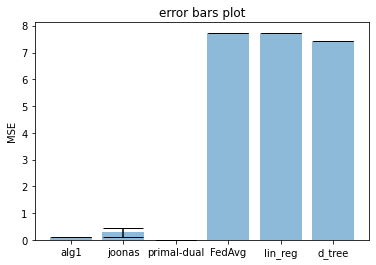

In [26]:
labels = ['alg1', 'joonas', 'primal-dual', 'FedAvg', 'lin_reg', 'd_tree']
x_pos = np.arange(len(labels))
    
    
print('algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in alg1_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in alg1_scores]))

print('joonas algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in joonas_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in joonas_scores]))

print('primal dual algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in primal_dual_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in primal_dual_scores]))

print('federated learning:', 
      '\n mean train MSE:', np.mean([item['train'] for item in fl_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in fl_scores])) 
                                                                         
print('linear regression:', 
      '\n mean train MSE:', np.mean([item['train'] for item in linear_regression_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in linear_regression_scores]))

print('decision tree:', 
      '\n mean train MSE:', np.mean([item['train'] for item in decision_tree_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in decision_tree_scores]))
    
alg1_norm1_score = [item['total'] for item in alg1_scores]
joonas_score = [item['total'] for item in joonas_scores]
primal_dual_score = [item['total'] for item in primal_dual_scores]
fl_score = [item['total'] for item in fl_scores]  
linear_regression_score = [item['total'] for item in linear_regression_scores]
decision_tree_score = [item['total'] for item in decision_tree_scores]

mean_MSEs = [
    np.mean(alg1_norm1_score), 
    np.mean(joonas_score), 
    np.mean(primal_dual_score), 
    np.mean(fl_score), 
    np.mean(linear_regression_score), 
    np.mean(decision_tree_score)
]

std_MSEs = [
    np.std(alg1_norm1_score), 
    np.std(joonas_score), 
    np.std(primal_dual_score), 
    np.std(fl_score),
    np.std(linear_regression_score), 
    np.std(decision_tree_score)
]


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    

## Results 

### Number of features: 10
### Number of datapoints per node: 100

In [96]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


PENALTY_FUNCS = ['norm1', 'norm2', 'mocha']

LAMBDA_LASSO = {'norm1': 0.1, 'norm2': 0.01, 'mocha': 0.05}

K = 1000

B, weight_vec, features, true_labels, datapoints = get_sbm_2blocks_data(pin=1.0, pout=0.01)
E, N = B.shape

alg1_scores = []
fl_scores = []
linear_regression_scores = []
decision_tree_scores = []

num_tries = 5
num_tries = 1

from joblib import Parallel, delayed
import multiprocessing
def fun():
    samplingset = random.sample([j for j in range(N)], k=int(0.8* N)) 
    lambda_lasso = 0.1
    _, primal_dual_w = primal_dual_algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso)
    _, predicted_w = algorithm_1(K, B, weight_vec, features, true_labels, samplingset, lambda_lasso)
    _, joona_w, _ = joonas_algorithm_1(K, B, weight_vec, features, true_labels, samplingset, lambda_lasso)
    _, fl_w = fedAvg(K, datapoints, true_labels, samplingset)

    return get_scores(features, true_labels, primal_dual_w, predicted_w, joona_w, fl_w, samplingset)


# results = Parallel(n_jobs=4)(delayed(fun)() 
#                                          for i in range(num_tries))

results = [fun()]

for scores in results:
    alg1_score, joonas_score, primal_dual_score, fl_score, linear_regression_score, decision_tree_score = scores
    alg1_scores.append(alg1_score)
    joonas_scores.append(joonas_score)
    primal_dual_scores.append(primal_dual_score)
    fl_scores.append(fl_score)
    linear_regression_scores.append(linear_regression_score)
    decision_tree_scores.append(decision_tree_score)

algorithm 1: 
 mean train MSE: 0.43649056873369757 
 mean test MSE: 0.7377765232946872
joonas algorithm 1: 
 mean train MSE: 0.26252792893721905 
 mean test MSE: 0.4728776251948603
primal dual algorithm 1: 
 mean train MSE: 0.00010928582386861215 
 mean test MSE: 0.0001282769593814781
federated learning: 
 mean train MSE: 40.491231107348305 
 mean test MSE: 41.3829951252406
linear regression: 
 mean train MSE: 40.42939923224336 
 mean test MSE: 41.3488742579035
decision tree: 
 mean train MSE: 40.40636673593412 
 mean test MSE: 39.6821741679441


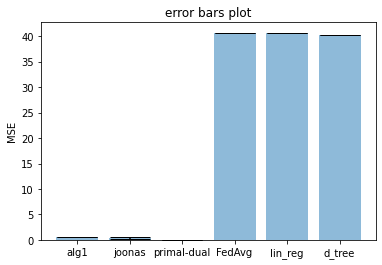

In [97]:
labels = ['alg1', 'joonas', 'primal-dual', 'FedAvg', 'lin_reg', 'd_tree']
x_pos = np.arange(len(labels))
    
    
print('algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in alg1_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in alg1_scores]))

print('joonas algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in joonas_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in joonas_scores]))

print('primal dual algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in primal_dual_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in primal_dual_scores]))

print('federated learning:', 
      '\n mean train MSE:', np.mean([item['train'] for item in fl_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in fl_scores])) 
                                                                         
print('linear regression:', 
      '\n mean train MSE:', np.mean([item['train'] for item in linear_regression_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in linear_regression_scores]))

print('decision tree:', 
      '\n mean train MSE:', np.mean([item['train'] for item in decision_tree_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in decision_tree_scores]))
    
alg1_norm1_score = [item['total'] for item in alg1_scores]
joonas_score = [item['total'] for item in joonas_scores]
primal_dual_score = [item['total'] for item in primal_dual_scores]
fl_score = [item['total'] for item in fl_scores]  
linear_regression_score = [item['total'] for item in linear_regression_scores]
decision_tree_score = [item['total'] for item in decision_tree_scores]

mean_MSEs = [
    np.mean(alg1_norm1_score), 
    np.mean(joonas_score), 
    np.mean(primal_dual_score), 
    np.mean(fl_score), 
    np.mean(linear_regression_score), 
    np.mean(decision_tree_score)
]

std_MSEs = [
    np.std(alg1_norm1_score), 
    np.std(joonas_score), 
    np.std(primal_dual_score), 
    np.std(fl_score),
    np.std(linear_regression_score), 
    np.std(decision_tree_score)
]


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    

## Results 

### Number of features: 50
### Number of datapoints per node: 100

In [98]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


PENALTY_FUNCS = ['norm1', 'norm2', 'mocha']

LAMBDA_LASSO = {'norm1': 0.1, 'norm2': 0.01, 'mocha': 0.05}

K = 1000

B, weight_vec, features, true_labels, datapoints = get_sbm_2blocks_data(pin=1.0, pout=0.01)
E, N = B.shape

alg1_scores = []
fl_scores = []
linear_regression_scores = []
decision_tree_scores = []

num_tries = 5
num_tries = 1

from joblib import Parallel, delayed
import multiprocessing
def fun():
    samplingset = random.sample([j for j in range(N)], k=int(0.8* N)) 
    lambda_lasso = 0.1
    _, primal_dual_w = primal_dual_algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso)
    _, primal_dual_w = primal_dual_algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso)
    _, predicted_w = algorithm_1(K, B, weight_vec, features, true_labels, samplingset, lambda_lasso)
    _, joona_w, _ = joonas_algorithm_1(K, B, weight_vec, features, true_labels, samplingset, lambda_lasso)
    _, fl_w = fedAvg(K, datapoints, true_labels, samplingset)

    return get_scores(features, true_labels, primal_dual_w, predicted_w, joona_w, fl_w, samplingset)


# results = Parallel(n_jobs=4)(delayed(fun)() 
#                                          for i in range(num_tries))

results = [fun()]

for scores in results:
    alg1_score, joonas_score, primal_dual_score, fl_score, linear_regression_score, decision_tree_score = scores
    alg1_scores.append(alg1_score)
    joonas_scores.append(joonas_score)
    primal_dual_scores.append(primal_dual_score)
    fl_scores.append(fl_score)
    linear_regression_scores.append(linear_regression_score)
    decision_tree_scores.append(decision_tree_score)



algorithm 1: 
 mean train MSE: 2.1680542248116357 
 mean test MSE: 3.4351167770013866
joonas algorithm 1: 
 mean train MSE: 0.7457423910151137 
 mean test MSE: 1.225186023200751
primal dual algorithm 1: 
 mean train MSE: 8.305430443125544e-05 
 mean test MSE: 9.722108766346568e-05
federated learning: 
 mean train MSE: 204.24332326808212 
 mean test MSE: 186.43711673305472
linear regression: 
 mean train MSE: 203.68646479070787 
 mean test MSE: 187.79678789641167
decision tree: 
 mean train MSE: 203.94844919792445 
 mean test MSE: 185.5021951939226


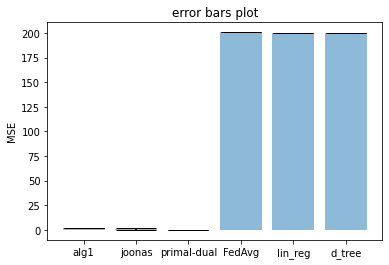

In [99]:
labels = ['alg1', 'joonas', 'primal-dual', 'FedAvg', 'lin_reg', 'd_tree']
x_pos = np.arange(len(labels))
    
    
print('algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in alg1_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in alg1_scores]))

print('joonas algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in joonas_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in joonas_scores]))

print('primal dual algorithm 1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in primal_dual_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in primal_dual_scores]))

print('federated learning:', 
      '\n mean train MSE:', np.mean([item['train'] for item in fl_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in fl_scores])) 
                                                                         
print('linear regression:', 
      '\n mean train MSE:', np.mean([item['train'] for item in linear_regression_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in linear_regression_scores]))

print('decision tree:', 
      '\n mean train MSE:', np.mean([item['train'] for item in decision_tree_scores]),
      '\n mean test MSE:', np.mean([item['test'] for item in decision_tree_scores]))
    
alg1_norm1_score = [item['total'] for item in alg1_scores]
joonas_score = [item['total'] for item in joonas_scores]
primal_dual_score = [item['total'] for item in primal_dual_scores]
fl_score = [item['total'] for item in fl_scores]  
linear_regression_score = [item['total'] for item in linear_regression_scores]
decision_tree_score = [item['total'] for item in decision_tree_scores]

mean_MSEs = [
    np.mean(alg1_norm1_score), 
    np.mean(joonas_score), 
    np.mean(primal_dual_score), 
    np.mean(fl_score), 
    np.mean(linear_regression_score), 
    np.mean(decision_tree_score)
]

std_MSEs = [
    np.std(alg1_norm1_score), 
    np.std(joonas_score), 
    np.std(primal_dual_score), 
    np.std(fl_score),
    np.std(linear_regression_score), 
    np.std(decision_tree_score)
]


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    